In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import logging
import warnings
from random import shuffle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import class_weight
import umap

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [4]:
logging.basicConfig(
        filename='doc2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Load Data

In [38]:
df = pd.read_parquet('combined.parquet', engine='fastparquet').loc[:, ['stars', 'text']]

In [39]:
df.stars.value_counts()

5    2641880
4    1335957
1     858139
3     673206
2     487813
Name: stars, dtype: int64

In [91]:
stars = range(1, 6)

In [40]:
sample = pd.concat([df[df.stars==s].sample(n=100000) for s in stars])

In [41]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 52085 to 3365007
Data columns (total 2 columns):
stars    500000 non-null int64
text     500000 non-null object
dtypes: int64(1), object(1)
memory usage: 11.4+ MB


In [66]:
sample.stars = (sample.stars == 5).astype(int)

In [42]:
sample.stars.value_counts()

5    100000
4    100000
3    100000
2    100000
1    100000
Name: stars, dtype: int64

In [43]:
sample.to_parquet('yelp_sample_5.parquet')

In [12]:
sample = pd.read_parquet('yelp_sample.parquet').reset_index(drop=True)

In [44]:
sample.head()

,stars,text
52085,1,Just terrible.\n\nI used to love Chili's - it ...
527763,1,"I love Cold Stone ice cream, but this location..."
3797997,1,I don't understand why people give this place ...
4715860,1,Terrible disappointment. It was a special cel...
2230375,1,Staff is awful. One called his coworker a bitc...


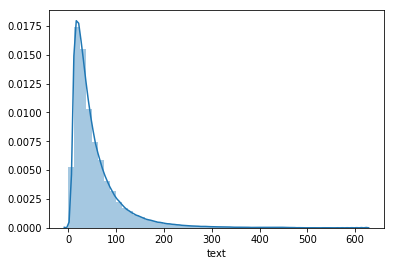

In [17]:
sns.distplot(sample.text.str.split().str.len());

## Doc2Vec

### Basic text cleaning

In [45]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def clean(review):
    tokens = tokenizer.tokenize(review)
    return ' '.join([t for t in tokens if t not in stopword_set])

In [46]:
sample.text = sample.text.str.lower().apply(clean)

In [47]:
sample.sample(n=10)

,stars,text
3713191,1,called 938 placed order informer ian manager a...
3632813,3,ok best tip sell stuff buffalo exchange sharin...
1414414,5,afford rooms well worth money absolutely amazi...
4609094,3,little bit pricier nw competition peak hours d...
4996179,4,great pigging comfort food visiting great frie...
1826950,5,went sun auto fri mar 9th dealt patrick mantan...
4210188,5,went nail salon must say impressed level custo...
1354353,5,rita must love custard black cherry little bit...
2760,1,drittes goa pfaffing erlebt absolut nix unterh...
1118726,1,visited week ago im finally writing review pla...


In [48]:
sample = sample[sample.text.str.split().str.len()>10]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485681 entries, 52085 to 3365007
Data columns (total 2 columns):
stars    485681 non-null int64
text     485681 non-null object
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


### Create sentence stream

In [49]:
sentences = []
for i, (_, text) in enumerate(sample.values):
    sentences.append(TaggedDocument(words=text.split(), tags=[i]))

### Formulate the model

In [50]:
size=300
window=5
min_count=0
epochs=5
negative=5
dm = 1
dm_concat=0
dbow_words=0
workers = 8

In [ ]:
model = Doc2Vec(documents=sentences,
                dm=1,
                size=size,
                window=window,
                min_count=min_count,
                workers=workers,
                epochs=epochs,
                negative=negative,
                dm_concat=dm_concat,
                dbow_words=dbow_words)

In [51]:
model = Doc2Vec(documents=sentences,
                dm=dm,
                size=size,
                window=window,
                min_count=min_count,
                workers=workers,
                epochs=epochs,
                negative=negative,
                dm_concat=dm_concat,
                dbow_words=dbow_words)

In [90]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [52]:
pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])

,token,similarity
0,great,0.869434
1,decent,0.824517
2,ok,0.759463
3,bad,0.749852
4,amazing,0.748687
5,awesome,0.733886
6,okay,0.719382
7,tasty,0.707188
8,nice,0.702621
9,delicious,0.692123


## Persist Model

In [53]:
model.save('sample5.model')

In [6]:
model = Doc2Vec.load('sample.model')

## Evaluate

In [62]:
y = sample.stars.sub(1)

In [55]:
X = np.zeros(shape=(len(y), size))
for i in range(len(sample)):
    X[i] = model.docvecs[i]

In [56]:
X.shape

(485681, 300)

### Train-Test Split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
mode = pd.Series(y_train).mode().iloc[0]
baseline = accuracy_score(y_true=y_test, y_pred=np.full_like(y_test, fill_value=mode))
print(f'Baseline Score: {baseline:.2%}')

Baseline Score: 20.16%


In [26]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [27]:
class_weights

array([0.52585038, 1.59482003, 2.12184306])

## LightGBM

In [65]:
train_data = lgb.Dataset(data=X_train, label=y_train)
test_data = train_data.create_valid(X_test, label=y_test)

In [66]:
params = {'objective': 'multiclass',
          'num_classes': 5}

In [67]:
lgb_model = lgb.train(params=params,
                      train_set=train_data,
                      num_boost_round=250,
                      valid_sets=[train_data, test_data],
                      verbose_eval=25)

[25]	training's multi_logloss: 1.50257	valid_1's multi_logloss: 1.51211
[50]	training's multi_logloss: 1.45251	valid_1's multi_logloss: 1.4704
[75]	training's multi_logloss: 1.41546	valid_1's multi_logloss: 1.44103
[100]	training's multi_logloss: 1.38507	valid_1's multi_logloss: 1.41809
[125]	training's multi_logloss: 1.35921	valid_1's multi_logloss: 1.39942
[150]	training's multi_logloss: 1.33601	valid_1's multi_logloss: 1.38295
[175]	training's multi_logloss: 1.31554	valid_1's multi_logloss: 1.36904
[200]	training's multi_logloss: 1.29656	valid_1's multi_logloss: 1.35624
[225]	training's multi_logloss: 1.27918	valid_1's multi_logloss: 1.34486
[250]	training's multi_logloss: 1.26276	valid_1's multi_logloss: 1.33447


In [72]:
y_pred = np.argmax(lgb_model.predict(X_test), axis=1)

In [88]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

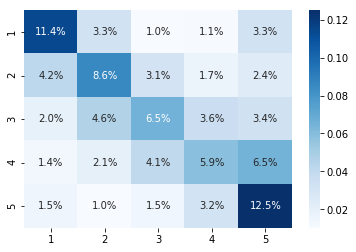

In [99]:
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%')

In [81]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.44955063467061984

In [36]:
roc_auc_score(y_score=lgb_model.predict(X_test), y_true=y_test)

0.8614708105573701

In [55]:
pd.DataFrame(lgb_model.predict(X_test)).describe()

,0,1,2
count,139717.000000,139717.000000,139717.000000
mean,0.630986,0.209083,0.159931
std,0.007147,0.005648,0.004706
min,0.502827,0.152388,0.110754
25%,0.629275,0.206945,0.158686
50%,0.630822,0.208772,0.160465
75%,0.632655,0.210202,0.161593
max,0.700247,0.337525,0.262446


## Random Forest

In [28]:
rf = RandomForestClassifier(n_jobs=-1,  
                            n_estimators=100,
                            class_weight='balanced_subsample')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.2%}')

Accuracy: 63.39%


In [38]:
y_pred_prob = rf.predict_proba(X_test)

In [39]:
pd.DataFrame(y_pred_prob).describe()

,0,1,2
count,139717.000000,139717.000000,139717.000000
mean,0.635541,0.207648,0.156812
std,0.048588,0.041110,0.036620
min,0.190000,0.050000,0.030000
25%,0.600000,0.180000,0.130000
50%,0.640000,0.210000,0.160000
75%,0.670000,0.230000,0.180000
max,0.860000,0.740000,0.340000


In [36]:
pd.Series(y_pred).value_counts()

0    139715
1         2
dtype: int64

In [32]:
pd.Series(y_train).value_counts()

0    354263
1    116809
2     87796
dtype: int64

In [33]:
(y_test == 0).mean()

0.6338956605137528

In [29]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[88564,     2,     0],
       [29202,     0,     0],
       [21949,     0,     0]])

## Logistic Regression

### Binary Classification

In [44]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.2%}')

Accuracy: 50.05%


### Multinomial Classification

In [100]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.2%}')

Accuracy: 34.60%


In [101]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 7624,  3105,  1792,  2075,  4929],
       [ 4957,  5365,  3126,  2027,  4111],
       [ 3142,  3631,  4546,  3171,  5017],
       [ 2301,  1756,  3307,  4580,  7430],
       [ 1742,   888,  1363,  3653, 11499]])